# Machine Learning on Elo Merchant Category Recommendation

Use the "Run" button to execute the code.

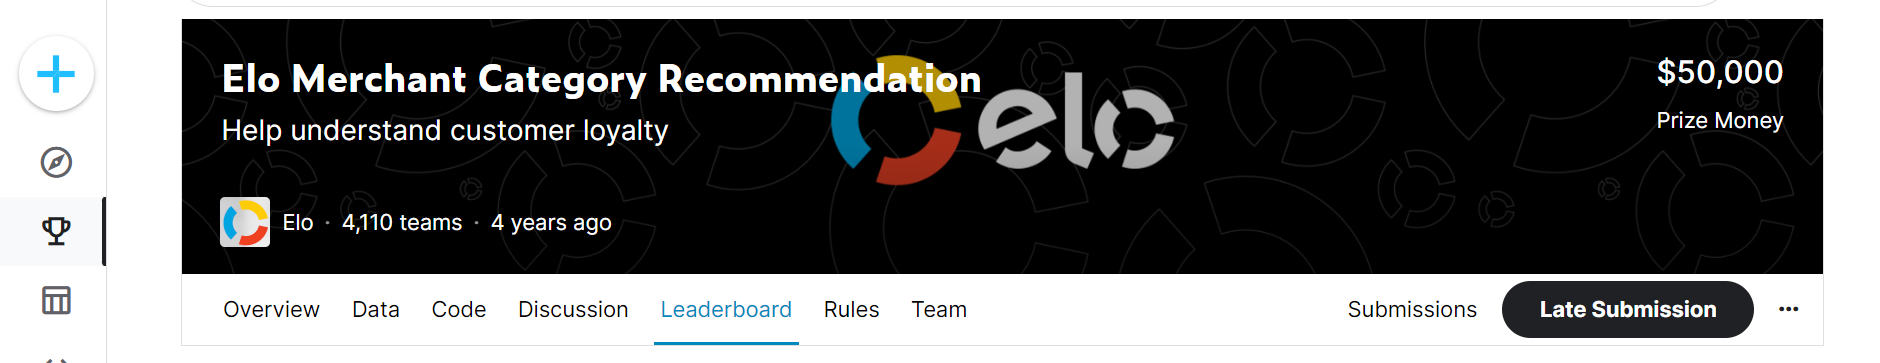

In [ ]:
print('Hello World')

Hello World


### Installation the required librabry and import it

In [ ]:
!pip install numpy matplotlib seaborn pandas-profiling --quiet

!pip install opendatasets scikit-learn --quiet --upgrade

from ast import increment_lineno
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize']=(15,5)
matplotlib.rcParams['figure.facecolor']= '#00000000'



The following steps will be cover during modelling:

* Downloading a real-world dataset from a Kaggle competition
* Read all csv file and use parse_dates in train and test dataset
* split `first_active_month` column into year, month and days
* Use Exploratory Data Analysis to find out which columns are more effective for modelling.
* Spliting training data into train and validation sets.
* Aplly preprocessing like imputation, scalling and one hot coding before modelling.
* modelling using linear regression, lasso regression, Ridge regression and XGBRegression.
* Apply different Hyperparameter and tune it for that model which has less rmse value
* Finally find the prediction for the test dataset using that model which has less rmse value with train and validation dataset

### Downloading a real-world dataset from a Kaggle competition

In [ ]:
od.download('https://www.kaggle.com/c/elo-merchant-category-recommendation', force=True)



100%|██████████| 615M/615M [00:05<00:00, 124MB/s]



Extracting archive ./elo-merchant-category-recommendation/elo-merchant-category-recommendation.zip to ./elo-merchant-category-recommendation


In [ ]:
os.listdir('./elo-merchant-category-recommendation')

['historical_transactions.csv',
 'merchants.csv',
 'train.csv',
 'test.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'Data_Dictionary.xlsx',
 'Data Dictionary.xlsx']

### Read all csv file and use parse_dates in train and test dataset

In [ ]:
testing_df= pd.read_csv('./elo-merchant-category-recommendation/test.csv', parse_dates=["first_active_month"])
training_df= pd.read_csv('./elo-merchant-category-recommendation/train.csv', parse_dates=["first_active_month"])
merchants_df= pd.read_csv('./elo-merchant-category-recommendation/merchants.csv')
new_merchant_trans_df= pd.read_csv('./elo-merchant-category-recommendation/new_merchant_transactions.csv')
sample_submission_df= pd.read_csv('./elo-merchant-category-recommendation/sample_submission.csv')

In [ ]:
training_df.sample(5)

first_active_month          card_id  feature_1  feature_2  feature_3  \
130064         2016-04-01  C_ID_7cba4c7fc4          3          3          1   
165580         2016-10-01  C_ID_31ab54fb58          3          3          1   
136741         2017-09-01  C_ID_11e115a00f          2          1          0   
183779         2017-07-01  C_ID_8563a0b654          5          2          1   
97376          2016-11-01  C_ID_6b007504d9          5          1          1   

          target  
130064 -0.363703  
165580 -2.125927  
136741  2.307858  
183779 -1.620790  
97376  -1.579460

In [ ]:
testing_df.sample(5)

first_active_month          card_id  feature_1  feature_2  feature_3
105956         2017-01-01  C_ID_3fb94a3251          3          2          1
6523           2017-05-01  C_ID_03b81f4065          5          2          1
6319           2016-08-01  C_ID_e9c97f49db          3          2          1
20127          2016-11-01  C_ID_a2e6440438          5          1          1
88109          2017-11-01  C_ID_a4bca536e7          3          2          1

In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   target              201917 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [ ]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   feature_1           123623 non-null  int64         
 3   feature_2           123623 non-null  int64         
 4   feature_3           123623 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


### Split datetime column into year, month and days

In [ ]:
import datetime

for df in [training_df, testing_df]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['start_year'] = df['first_active_month'].dt.year
    df['start_month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days



In [ ]:
training_df.shape

(201917, 9)

In [ ]:
testing_df.shape

(123623, 8)

In [ ]:
training_df.sample(5)

first_active_month          card_id  feature_1  feature_2  feature_3  \
107416         2017-11-01  C_ID_0041e2e444          3          1          1   
56343          2017-11-01  C_ID_bcb26a36ae          2          1          0   
197876         2017-07-01  C_ID_fa24a65dc2          4          1          0   
83601          2017-09-01  C_ID_8288a1e64b          2          3          0   
90031          2015-12-01  C_ID_3fe9e79a97          1          2          0   

          target  start_year  start_month  elapsed_time  
107416 -3.488038        2017           11            92  
56343  -0.063987        2017           11            92  
197876  0.296943        2017            7           215  
83601   0.120844        2017            9           153  
90031   0.000000        2015           12           793

In [ ]:
sample_submission_df

card_id  target
0       C_ID_0ab67a22ab       0
1       C_ID_130fd0cbdd       0
2       C_ID_b709037bc5       0
3       C_ID_d27d835a9f       0
4       C_ID_2b5e3df5c2       0
...                 ...     ...
123618  C_ID_7a239d2eda       0
123619  C_ID_75ace375ae       0
123620  C_ID_21d56d950c       0
123621  C_ID_6c46fc5a9d       0
123622  C_ID_87e7979a5f       0

[123623 rows x 2 columns]

## Use Exploratory Data Analysis to find out which columns are more effective for modelling

In [ ]:
!pip install plotly --upgrade --quiet

In [ ]:
import plotly.express as px

**Visualization of target column of training dataset that how it has distributed**

In [ ]:
plt.figure(figsize=(5,3)),
fig=px.histogram(training_df,
                 x='target',
                 nbins=50,
                 color_discrete_sequence=['purple'],
                 title= 'target Distribution')
fig.update_layout(bargap=0.1)
fig.show()

<Figure size 360x216 with 0 Axes>

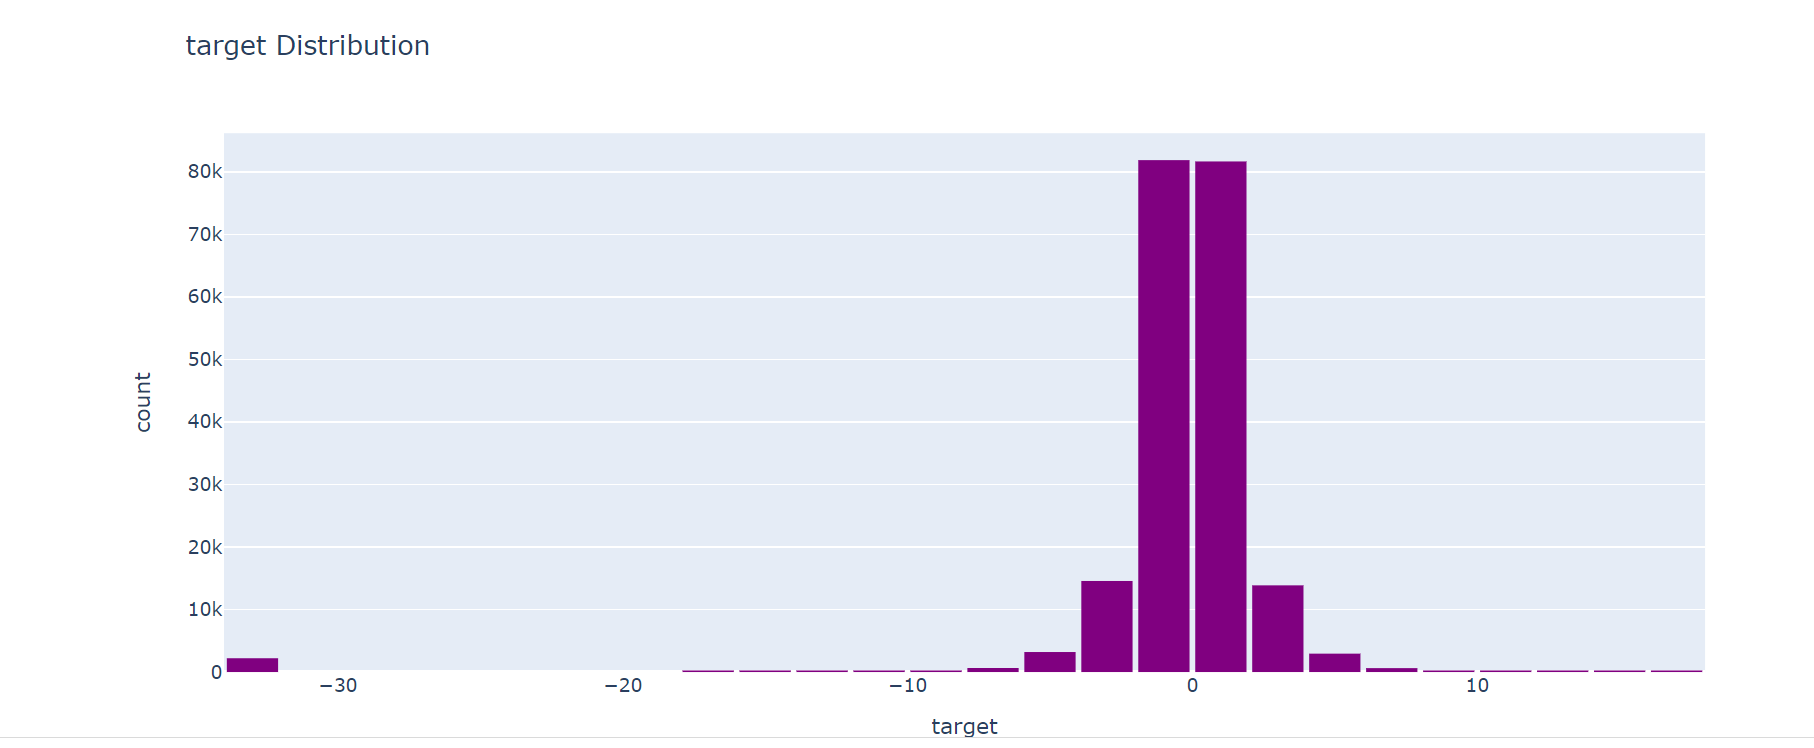

Above target distribution graph shows that there is an outlier which is too far from the normal value which is target(-32 ti -34). Target from -2 to 2 is more effective in this dataset

**Relation of anonymized value feature_3(zero and one) vs target**

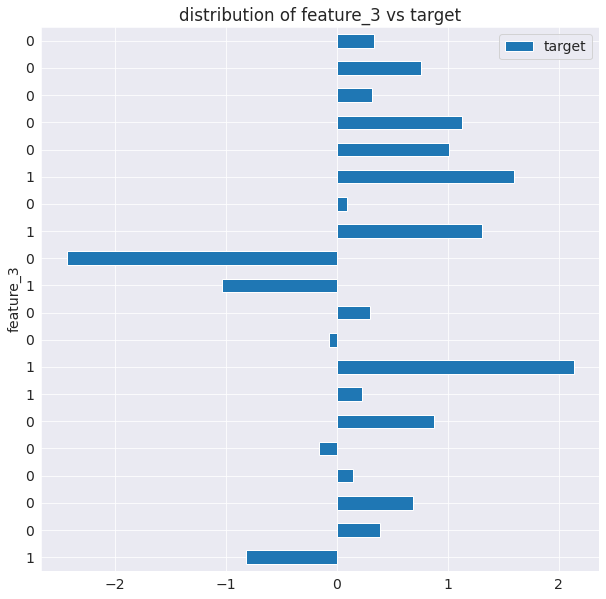

In [ ]:
matplotlib.rcParams['figure.figsize']=(10,10)
training_df.head(20).plot.barh(x='feature_3', y='target', title='distribution of feature_3 vs target');

Above graph between feature_3 and target shows that ananymised value 0 is more effective than the value 1. Value 0 is contributing positively for target accomplishment

**Relation of anonymized value feature_1 (one, two, three, four and five) vs target**

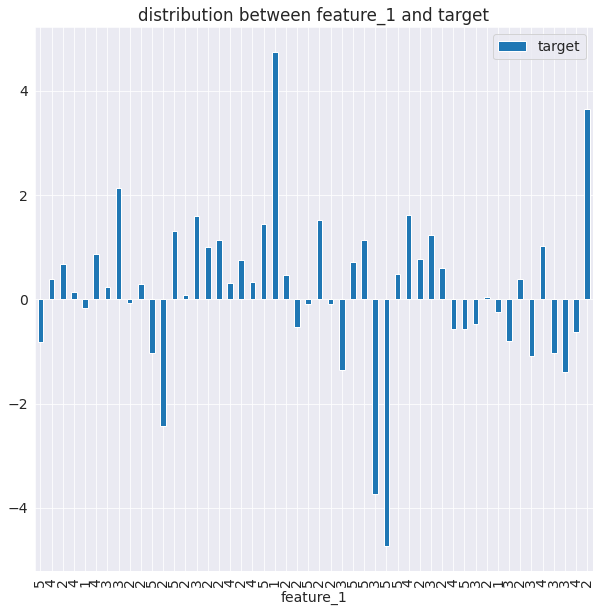

In [ ]:
training_df.head(50).plot.bar(x='feature_1', y='target', title='distribution between feature_1 and target');

Above graph between feature_1 and target reflect that target 2 and 4 is more effective than target -2 and -4

**Relation of anonymized value feature_2(one, two and three) vs target**

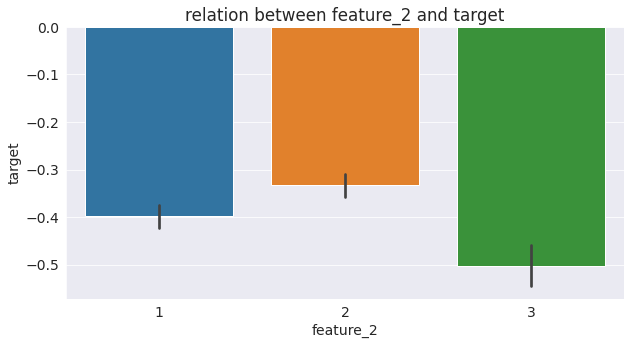

In [ ]:
plt.figure(figsize=(10,5))
plt.title('relation between feature_2 and target')
sns.barplot(data=training_df, x='feature_2', y='target');


graph between feature_2 and target shows that ananymised value 2 is more important than the value 1 and 3 because value 2 is effecting less negative impact on target as compared to the value 1 and 3. value 3 is impacting more negative in above visualization

**Visualization of Elapsed time(total number of day) when card has used for shopping**

In [ ]:
plt.figure(figsize=(5,3)),
fig=px.histogram(training_df,
                 x='elapsed_time',
                 nbins=50,
                 color_discrete_sequence=['green'],
                 title= 'Elapsed time Distribution')
fig.update_layout(bargap=0.1)
fig.show();

<Figure size 360x216 with 0 Axes>

As per the above elapsed time distribution graph(total number of days that card_id is used)customers using card for purchasing are interval from 50 days to 500 day and after that purchasing frequency is decreasing sharply.

## Spliting training data into `train_df` and `val_df` sets




### Training, Validation and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(training_df, test_size=0.2, random_state=42)

In [ ]:
print('train_df shape', train_df.shape)
print('val_df shape', val_df.shape)
print('test_df shape', testing_df.shape)

train_df shape (161533, 9)
val_df shape (40384, 9)
test_df shape (123623, 8)


## Apply preprocessing like imputation, scalling and one hot coding before modelling



### Preprocessing

In [ ]:
input_cols= training_df.columns.drop(['target','first_active_month', 'card_id'])

In [ ]:
input_cols

Index(['feature_1', 'feature_2', 'feature_3', 'start_year', 'start_month',
       'elapsed_time'],
      dtype='object')

In [ ]:
target_cols= 'target'

In [ ]:
train_inputs= training_df[input_cols].copy()
train_targets=training_df[target_cols].copy()

In [ ]:
val_inputs= val_df[input_cols].copy()
val_targets= val_df[target_cols].copy()

In [ ]:
test_inputs=testing_df[input_cols].copy()

In [ ]:
test_inputs

feature_1  feature_2  feature_3  start_year  start_month  elapsed_time
0               3          3          1      2017.0          4.0         306.0
1               2          3          0      2017.0          1.0         396.0
2               5          1          1      2017.0          8.0         184.0
3               2          1          0      2017.0         12.0          62.0
4               5          1          1      2015.0         12.0         793.0
...           ...        ...        ...         ...          ...           ...
123618          2          2          0      2017.0         10.0         123.0
123619          3          1          1      2017.0          9.0         153.0
123620          5          1          1      2016.0          9.0         518.0
123621          2          1          0      2017.0          6.0         245.0
123622          5          1          1      2016.0         10.0         488.0

[123623 rows x 6 columns]

In [ ]:
train_targets

0        -0.820283
1         0.392913
2         0.688056
3         0.142495
4        -0.159749
            ...   
201912   -2.740821
201913    0.312917
201914    0.093494
201915   -4.676589
201916   -1.859413
Name: target, Length: 201917, dtype: float64

In [ ]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   feature_1     201917 non-null  int64
 1   feature_2     201917 non-null  int64
 2   feature_3     201917 non-null  int64
 3   start_year    201917 non-null  int64
 4   start_month   201917 non-null  int64
 5   elapsed_time  201917 non-null  int64
dtypes: int64(6)
memory usage: 9.2 MB


In [ ]:
numeric_cols=  ['elapsed_time']
categorical_cols= ['feature_1', 'feature_2', 'feature_3', 'start_year', 'start_month']

In [ ]:
train_df[numeric_cols].describe()

elapsed_time
count  161533.000000
mean      381.419438
std       292.947186
min        31.000000
25%       153.000000
50%       306.000000
75%       488.000000
max      2284.000000

### Imputation

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer= SimpleImputer(strategy= 'most_frequent').fit(training_df[numeric_cols])

In [ ]:
train_inputs[numeric_cols]= imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]= imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]= imputer.transform(test_inputs[numeric_cols])

In [ ]:
train_inputs[numeric_cols].isna().sum()

elapsed_time    0
dtype: int64

### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler= MinMaxScaler().fit(training_df[numeric_cols])

In [ ]:
train_inputs[numeric_cols]= scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]= scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]= scaler.transform(test_inputs[numeric_cols])

### one hot coding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder =OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(training_df[categorical_cols])


In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
print(encoded_cols, end= " ")

['feature_1_1', 'feature_1_2', 'feature_1_3', 'feature_1_4', 'feature_1_5', 'feature_2_1', 'feature_2_2', 'feature_2_3', 'feature_3_0', 'feature_3_1', 'start_year_2011', 'start_year_2012', 'start_year_2013', 'start_year_2014', 'start_year_2015', 'start_year_2016', 'start_year_2017', 'start_year_2018', 'start_month_1', 'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5', 'start_month_6', 'start_month_7', 'start_month_8', 'start_month_9', 'start_month_10', 'start_month_11', 'start_month_12'] 

In [ ]:
train_inputs[encoded_cols]= encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols]= encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols]= encoder.transform(test_inputs[categorical_cols])

In [ ]:
test_inputs.sample(5)

feature_1  feature_2  feature_3  start_year  start_month  \
120133          2          1          0      2017.0          5.0   
57000           3          3          1      2017.0          9.0   
73472           2          2          0      2017.0         11.0   
58636           5          2          1      2017.0         11.0   
97058           2          3          0      2017.0          9.0   

        elapsed_time  feature_1_1  feature_1_2  feature_1_3  feature_1_4  \
120133      0.120841          0.0          1.0          0.0          0.0   
57000       0.066988          0.0          0.0          1.0          0.0   
73472       0.040280          0.0          1.0          0.0          0.0   
58636       0.040280          0.0          0.0          0.0          0.0   
97058       0.066988          0.0          1.0          0.0          0.0   

        feature_1_5  feature_2_1  feature_2_2  feature_2_3  feature_3_0  \
120133          0.0          1.0          0.0          0.0          1.0   
57000           0.0          0.0          0.0          1.0          0.0   
73472           0.0          0.0          1.0          0.0          1.0   
58636           1.0          0.0          1.0          0.0          0.0   
97058           0.0          0.0          0.0          1.0          1.0   

        feature_3_1  start_year_2011  start_year_2012  start_year_2013  \
120133          0.0              0.0              0.0              0.0   
57000           1.0              0.0              0.0              0.0   
73472           0.0              0.0              0.0              0.0   
58636           1.0              0.0              0.0              0.0   
97058           0.0              0.0              0.0              0.0   

        start_year_2014  start_year_2015  start_year_2016  start_year_2017  \
120133              0.0              0.0              0.0              1.0   
57000               0.0              0.0              0.0              1.0   
73472               0.0              0.0              0.0              1.0   
58636               0.0              0.0              0.0              1.0   
97058               0.0              0.0              0.0              1.0   

        start_year_2018  start_month_1  start_month_2  start_month_3  \
120133              0.0            0.0            0.0            0.0   
57000               0.0            0.0            0.0            0.0   
73472               0.0            0.0            0.0            0.0   
58636               0.0            0.0            0.0            0.0   
97058               0.0            0.0            0.0            0.0   

        start_month_4  start_month_5  start_month_6  start_month_7  \
120133            0.0            1.0            0.0            0.0   
57000             0.0            0.0            0.0            0.0   
73472             0.0            0.0            0.0            0.0   
58636             0.0            0.0            0.0            0.0   
97058             0.0            0.0            0.0            0.0   

        start_month_8  start_month_9  start_month_10  start_month_11  \
120133            0.0            0.0             0.0             0.0   
57000             0.0            1.0             0.0             0.0   
73472             0.0            0.0             0.0             1.0   
58636             0.0            0.0             0.0             1.0   
97058             0.0            1.0             0.0             0.0   

        start_month_12  
120133             0.0  
57000              0.0  
73472              0.0  
58636              0.0  
97058              0.0

In [ ]:
X_train= train_inputs[numeric_cols+ encoded_cols]
X_val= val_inputs[numeric_cols+ encoded_cols]
X_test= test_inputs[numeric_cols+ encoded_cols]

## Modelling using linear regression, lasso regression, Ridge regression and XGBRegression

### Linear Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model=LinearRegression()

In [ ]:
model.fit(X_train, train_targets)

LinearRegression()

In [ ]:
predictions=model.predict(X_train)

In [ ]:
predictions

array([-0.30224609, -0.69824219, -0.5078125 , ..., -0.35791016,
       -0.47753906, -0.21923828])

In [ ]:
import numpy as np

Define root mean square error

In [ ]:
def rmse(targets, predictions):
  return np.sqrt(np.mean(np.square(targets - predictions)))


rmse for train dataset

In [ ]:
rmse(train_targets, predictions)

3.842601950491683

In [ ]:
predictions_val= model.predict(X_val)

rmse for validation dataset

In [ ]:
rmse(val_targets, predictions_val)

3.8684471306579145

In [ ]:
model.score(X_train, train_targets)

0.004093208176428997

In [ ]:
model.score(X_val, val_targets)

0.003933890001728835

In [ ]:
model.coef_

array([ 7.44607804e+02, -4.78993128e+12, -4.78993128e+12, -4.08230419e+12,
       -4.78993128e+12, -4.08230419e+12,  3.10606735e+12,  3.10606735e+12,
        3.10606735e+12,  3.04361841e+11, -4.03265250e+11,  3.01691305e+11,
        3.01691305e+11,  3.01691305e+11,  3.01691305e+11,  3.01691306e+11,
        3.01691306e+11,  3.01691306e+11,  3.01691306e+11, -1.68589383e+12,
       -1.68589383e+12, -1.68589383e+12, -1.68589383e+12, -1.68589383e+12,
       -1.68589383e+12, -1.68589383e+12, -1.68589383e+12, -1.68589383e+12,
       -1.68589383e+12, -1.68589383e+12, -1.68589383e+12])

In [ ]:
model.intercept_

2763704610310.2896

### Lasso Regression Model

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
model= Lasso(alpha=0.1, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

Lasso(alpha=0.1, random_state=42)

In [ ]:
predictions= model.predict(X_train)


In [ ]:
predictions

array([-0.3936363, -0.3936363, -0.3936363, ..., -0.3936363, -0.3936363,
       -0.3936363])

rmse for train dataset

In [ ]:
rmse(train_targets, predictions)

3.8504904606159247

In [ ]:
predictions_val= model.predict(X_val)

rmse for validation dataset

In [ ]:
rmse(val_targets, predictions_val)

3.8760807539623268

In [ ]:
model.score(X_train, train_targets)

0.0

In [ ]:
model.score(X_val, val_targets)

-1.0716584641912164e-06

In [ ]:
model.coef_

array([-0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.])

model cofficient show 0 for all predictions. It means lasso regression is not fit for this dataset.

In [ ]:
model.intercept_

-0.3936362990779874

In [ ]:
X_train

elapsed_time  feature_1_1  feature_1_2  feature_1_3  feature_1_4  \
0           0.107268          0.0          0.0          0.0          0.0   
1           0.173380          0.0          0.0          0.0          1.0   
2           0.240368          0.0          1.0          0.0          0.0   
3           0.066988          0.0          0.0          0.0          1.0   
4           0.040280          1.0          0.0          0.0          0.0   
...              ...          ...          ...          ...          ...   
201912      0.066988          0.0          0.0          1.0          0.0   
201913      0.373905          0.0          0.0          1.0          0.0   
201914      0.080560          0.0          0.0          0.0          1.0   
201915      0.253940          0.0          0.0          1.0          0.0   
201916      0.094133          0.0          0.0          1.0          0.0   

        feature_1_5  feature_2_1  feature_2_2  feature_2_3  feature_3_0  \
0               1.0          0.0          1.0          0.0          0.0   
1               0.0          1.0          0.0          0.0          1.0   
2               0.0          0.0          1.0          0.0          1.0   
3               0.0          0.0          0.0          1.0          1.0   
4               0.0          0.0          0.0          1.0          1.0   
...             ...          ...          ...          ...          ...   
201912          0.0          0.0          1.0          0.0          0.0   
201913          0.0          1.0          0.0          0.0          0.0   
201914          0.0          0.0          0.0          1.0          1.0   
201915          0.0          0.0          1.0          0.0          0.0   
201916          0.0          1.0          0.0          0.0          0.0   

        feature_3_1  start_year_2011  start_year_2012  start_year_2013  \
0               1.0              0.0              0.0              0.0   
1               0.0              0.0              0.0              0.0   
2               0.0              0.0              0.0              0.0   
3               0.0              0.0              0.0              0.0   
4               0.0              0.0              0.0              0.0   
...             ...              ...              ...              ...   
201912          1.0              0.0              0.0              0.0   
201913          1.0              0.0              0.0              0.0   
201914          0.0              0.0              0.0              0.0   
201915          1.0              0.0              0.0              0.0   
201916          1.0              0.0              0.0              0.0   

        start_year_2014  start_year_2015  start_year_2016  start_year_2017  \
0                   0.0              0.0              0.0              1.0   
1                   0.0              0.0              0.0              1.0   
2                   0.0              0.0              1.0              0.0   
3                   0.0              0.0              0.0              1.0   
4                   0.0              0.0              0.0              1.0   
...                 ...              ...              ...              ...   
201912              0.0              0.0              0.0              1.0   
201913              0.0              1.0              0.0              0.0   
201914              0.0              0.0              0.0              1.0   
201915              0.0              0.0              1.0              0.0   
201916              0.0              0.0              0.0              1.0   

        start_year_2018  start_month_1  start_month_2  start_month_3  \
0                   0.0            0.0            0.0            0.0   
1                   0.0            1.0            0.0            0.0   
2                   0.0            0.0            0.0            0.0   
3                   0.0            0.0            0.0            0.0   
4       

### Ridge Regression Model





In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
model= Ridge(alpha=0.1, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

Ridge(alpha=0.1, random_state=42)

In [ ]:
predictions= model.predict(X_train)

In [ ]:
predictions

array([-0.31904041, -0.65583171, -0.48640395, ..., -0.36977106,
       -0.45940963, -0.22238865])

rmse for train dataset

In [ ]:
rmse(train_targets, predictions)

3.8427804640497207

In [ ]:
predictions_val= model.predict(X_val)

rmse for validation dataset

In [ ]:
rmse(val_targets, predictions_val)

3.868528506082127

In [ ]:
model.score(X_train, train_targets)

0.004000673484180539

In [ ]:
model.score(X_val, val_targets)

0.003891983700810786

In [ ]:
model.coef_

array([ 1.18761485,  0.0246401 ,  0.01108866,  0.06954871, -0.03348508,
       -0.07179239, -0.01689762,  0.10960959, -0.09271197,  0.00224368,
       -0.00224368, -0.81238694, -1.13828498, -0.59168796, -0.24656315,
        0.04134707,  0.23462024,  0.78793802,  1.7250177 , -0.36263126,
       -0.33057155, -0.31331266, -0.12759272, -0.01675822, -0.0310368 ,
        0.06638021,  0.10947769,  0.22899061,  0.2749297 ,  0.27653886,
        0.22558615])

In [ ]:
model.intercept_

-1.238908152106022

### Gradient Boosting machine model

In [ ]:
from xgboost import XGBRegressor

In [ ]:
base_model= XGBRegressor(random_state=42, n_jobs=-1)

In [ ]:
train_preds = base_model.fit(X_train,train_targets)

[11:55:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
predictions=base_model.predict(X_train)

In [ ]:
def rmse(targets, predictions):
  return np.sqrt(np.mean(np.square(targets - predictions)))


rmse for train dataset

In [ ]:
rmse(train_targets, predictions)

3.8384487252356516

In [ ]:
val_predictions= model.predict(X_val)

rmse for validation dataset

In [ ]:
rmse(val_targets, val_predictions )

3.868528506082127

**Let's define a helper function test_params to make it easy to test hyperparameters.**

In [ ]:
def test_params(**params):
  model = XGBRegressor(random_state=42, n_jobs=-1,**params).fit(X_train, train_targets)
  return rmse(train_targets, predictions), rmse(val_targets, val_predictions)


## Apply different Hyperparameter and tuning it for that model which has less rmse value

### max_depth=10

rmse for train and validation dataset for max_depth=10

In [ ]:
test_params(max_depth=10)

[11:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### max_depth=15

rmse for train and validation dataset for max_depth=15

In [ ]:
test_params(max_depth=15)

[11:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### max_depth=30

rmse for train and validation dataset for max_depth=30

In [ ]:
test_params(max_depth=30)

[11:59:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### n_estimators=20

rmse for train and validation dataset for n_estimators=20

In [ ]:
test_params(n_estimators=20)

[12:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### n_estimators=50

rmse for train and validation dataset for n_estimators=50

In [ ]:
test_params(n_estimators=50)

[12:01:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### n_estimators=75

rmse for train and validation dataset for n_estimators=75

In [ ]:
test_params(n_estimators=75)

[12:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

### n_estimators=100

rmse for train and validation dataset for n_estimators=100

In [ ]:
test_params(n_estimators=100)

[12:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(3.8384487252356516, 3.868528506082127)

Above applied different hyperparameter(max_depth=10,15 and 30, n_estimators= 20,50,75 and 100) are not reducing the sufficent amount of rmse value. But it also show that its rmse value for train and validation is least value than the other three model(linear, lasso and Ridge Regression). so we will apply XGBRegression for test data set and we will apply hyperparameter max-depth=20 and n_estimators=50

# Visualize tree using plot_tree
we can visualize individual trees using `plot_tree`. For this it needs `graphviz` library and it needs to be installed

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize']=30,30


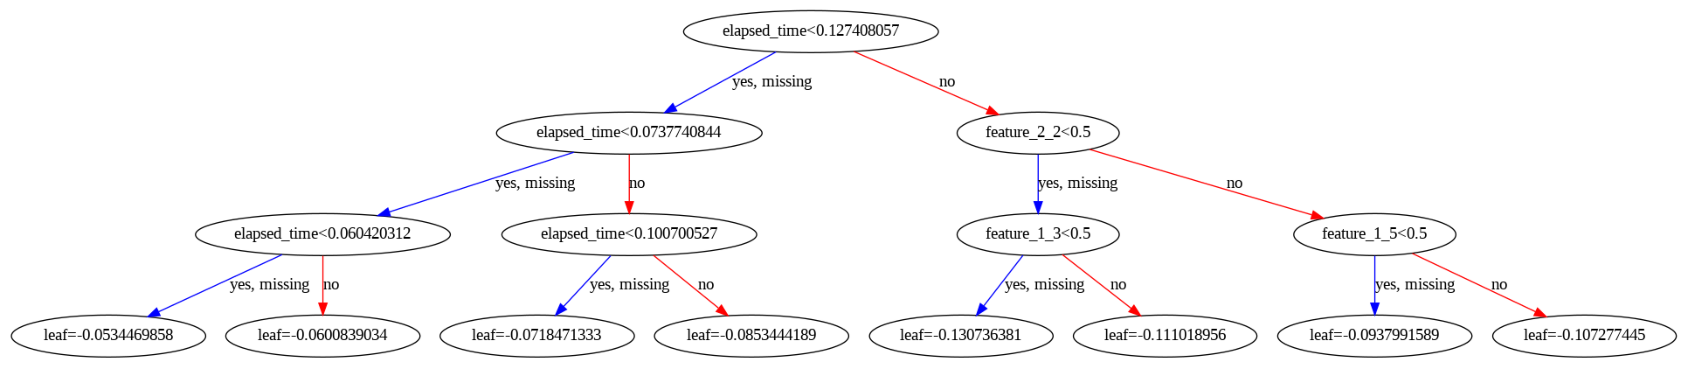

In [ ]:
plot_tree(base_model, randir='LR');

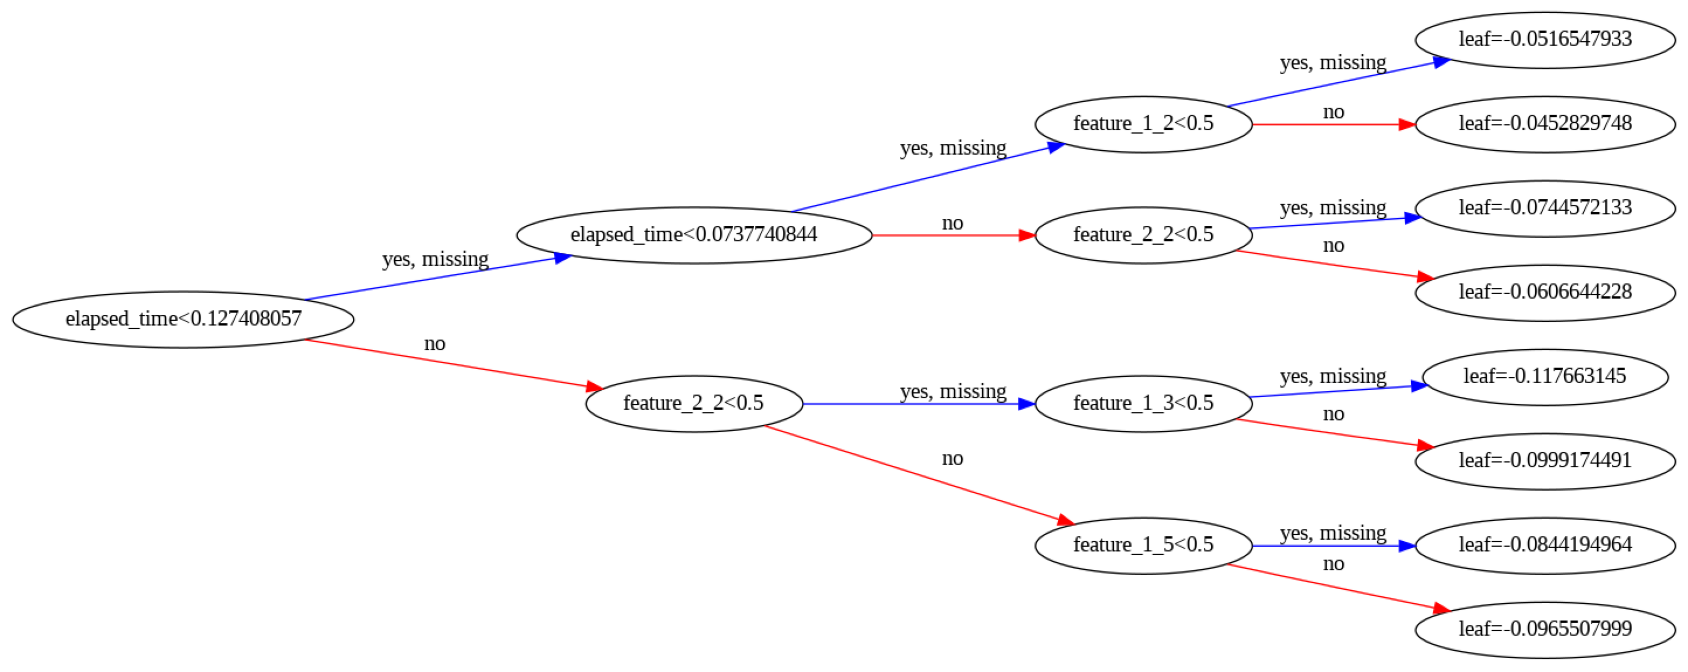

In [ ]:
plot_tree(base_model, rankdir='LR', num_trees=1);

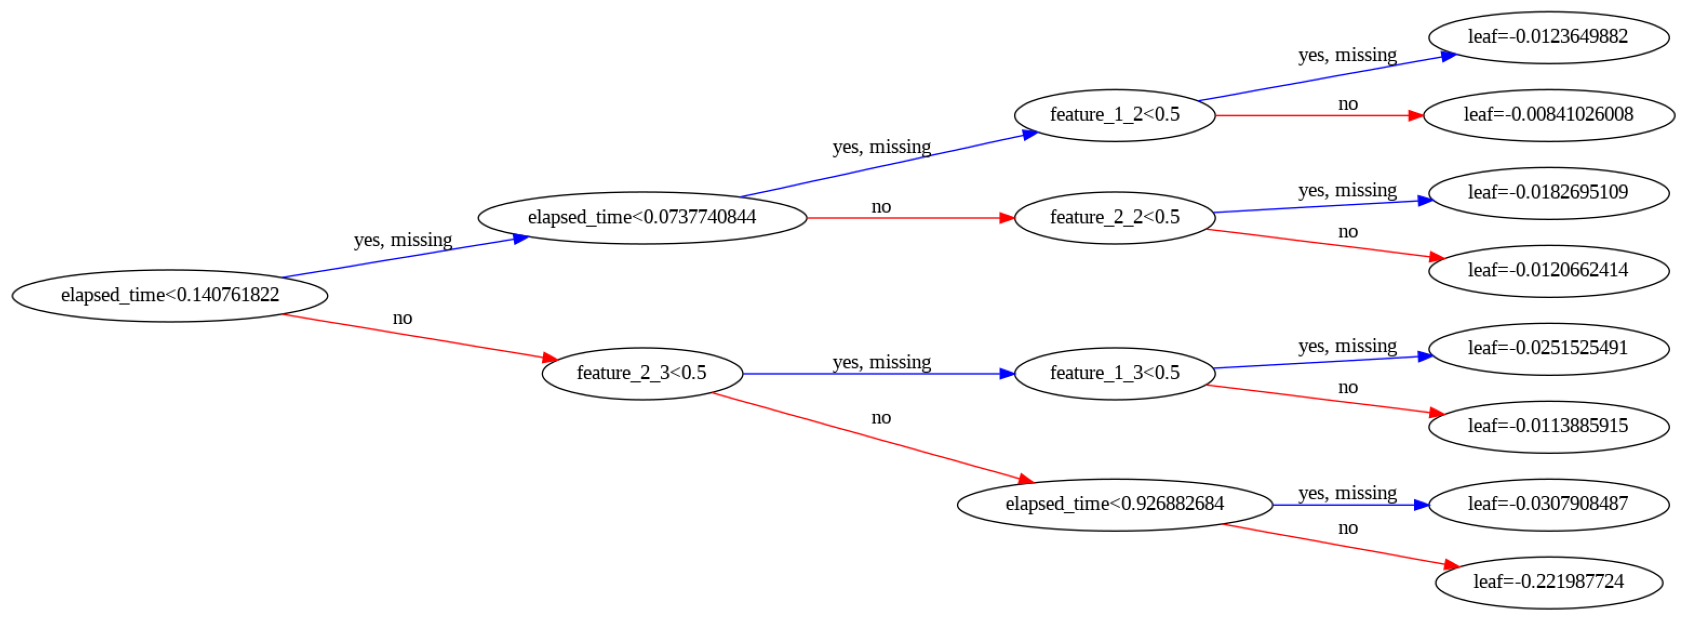

In [ ]:
plot_tree(base_model, rankdir='LR', num_trees=15);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [ ]:
trees= base_model.get_booster().get_dump()

In [ ]:
len(trees)

100

In [ ]:
print(trees[10])

0:[elapsed_time<0.140761822] yes=1,no=2,missing=1
	1:[elapsed_time<0.0873467624] yes=3,no=4,missing=3
		3:[elapsed_time<0.060420312] yes=7,no=8,missing=7
			7:leaf=-0.018399423
			8:leaf=-0.0221228432
		4:[feature_1_1<0.5] yes=9,no=10,missing=9
			9:leaf=-0.0298509654
			10:leaf=-0.0140460376
	2:[feature_2_3<0.5] yes=5,no=6,missing=5
		5:[feature_1_3<0.5] yes=11,no=12,missing=11
			11:leaf=-0.0418384783
			12:leaf=-0.0238233022
		6:[elapsed_time<0.926882684] yes=13,no=14,missing=13
			13:leaf=-0.049027849
			14:leaf=-0.300875813



# Feature Importance

In [ ]:
importance_df= pd.DataFrame({
    'feature' : X_train.columns,
    'importance' : base_model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df

feature  importance
0      elapsed_time    0.165465
7       feature_2_2    0.159346
3       feature_1_3    0.087860
26    start_month_8    0.056505
2       feature_1_2    0.044375
23    start_month_5    0.044117
22    start_month_4    0.043612
5       feature_1_5    0.040395
1       feature_1_1    0.040169
9       feature_3_0    0.038764
27    start_month_9    0.038353
20    start_month_2    0.036494
16  start_year_2016    0.027660
8       feature_2_3    0.026913
6       feature_2_1    0.024865
21    start_month_3    0.023368
19    start_month_1    0.016812
15  start_year_2015    0.016647
28   start_month_10    0.014810
29   start_month_11    0.013765
13  start_year_2013    0.011579
25    start_month_7    0.010474
4       feature_1_4    0.008802
24    start_month_6    0.006932
30   start_month_12    0.001919
18  start_year_2018    0.000000
17  start_year_2017    0.000000
14  start_year_2014    0.000000
12  start_year_2012    0.000000
11  start_year_2011    0.000000
10      feature_3_1    0.000000

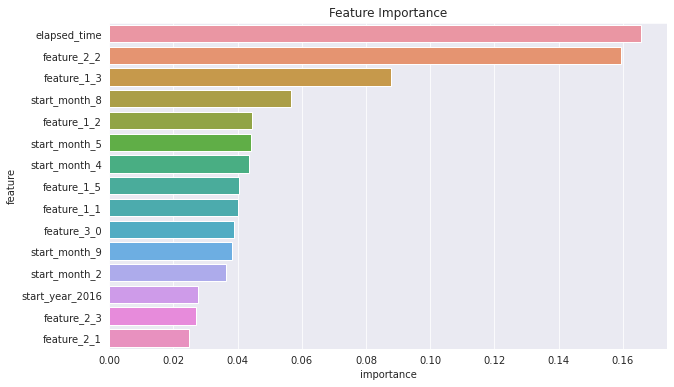

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data= importance_df.head(15), x='importance', y='feature');

# Compare all Train RMSE and Val RMSE of different applied models

From the above four model it is clear that it has four different rmse score

* In Linear Regression Model train RMSE is 3.84260 and val
RMSE is 3.86844
* In Lasso Regression Model train RMSE score is 3.8504904 and Val RMSE is 3.876081
* In Ridge Regression Model train RMSE score is 3.84278 and Val RMSE is 3.86852
* in GBM Regression Model train RMSE score is  3.83844 and val RMSE is 3.86852


Hence it is clear that in our Machine learning models, GBM regression model is best and has less RMSE score. So we will submit this score for the Kaggle competition

# Put it together and making it prediction for test data

**Prediction for test dataset**

As we found that hyperparameter `max_depth=20`, and `n_estimators50` are best with XGBRegression having `random_state=42` and `n_jobs=-1`

In [ ]:
model= XGBRegressor(random_state=42, n_jobs=-1, max_depth=20, n_estimators=50).fit(X_train, train_targets)

[12:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test = model.predict(X_test)

In [ ]:
testing_df.shape

(123623, 8)

In [ ]:
test.shape

(123623,)

**Create submission dataframe**

In [ ]:
submission_df= pd.DataFrame({
    'card_id' : testing_df.card_id,
    'target' : test
})

In [ ]:
submission_df

card_id    target
0       C_ID_0ab67a22ab -0.631425
1       C_ID_130fd0cbdd -0.674569
2       C_ID_b709037bc5 -0.151119
3       C_ID_d27d835a9f  0.016176
4       C_ID_2b5e3df5c2 -0.600442
...                 ...       ...
123618  C_ID_7a239d2eda -0.022024
123619  C_ID_75ace375ae -0.177094
123620  C_ID_21d56d950c -0.907300
123621  C_ID_6c46fc5a9d -0.441759
123622  C_ID_87e7979a5f -0.501736

[123623 rows x 2 columns]

**Convert into csv file to submit it in kaggel competation**

In [ ]:
submission_df.to_csv('submission.csv', index=False)

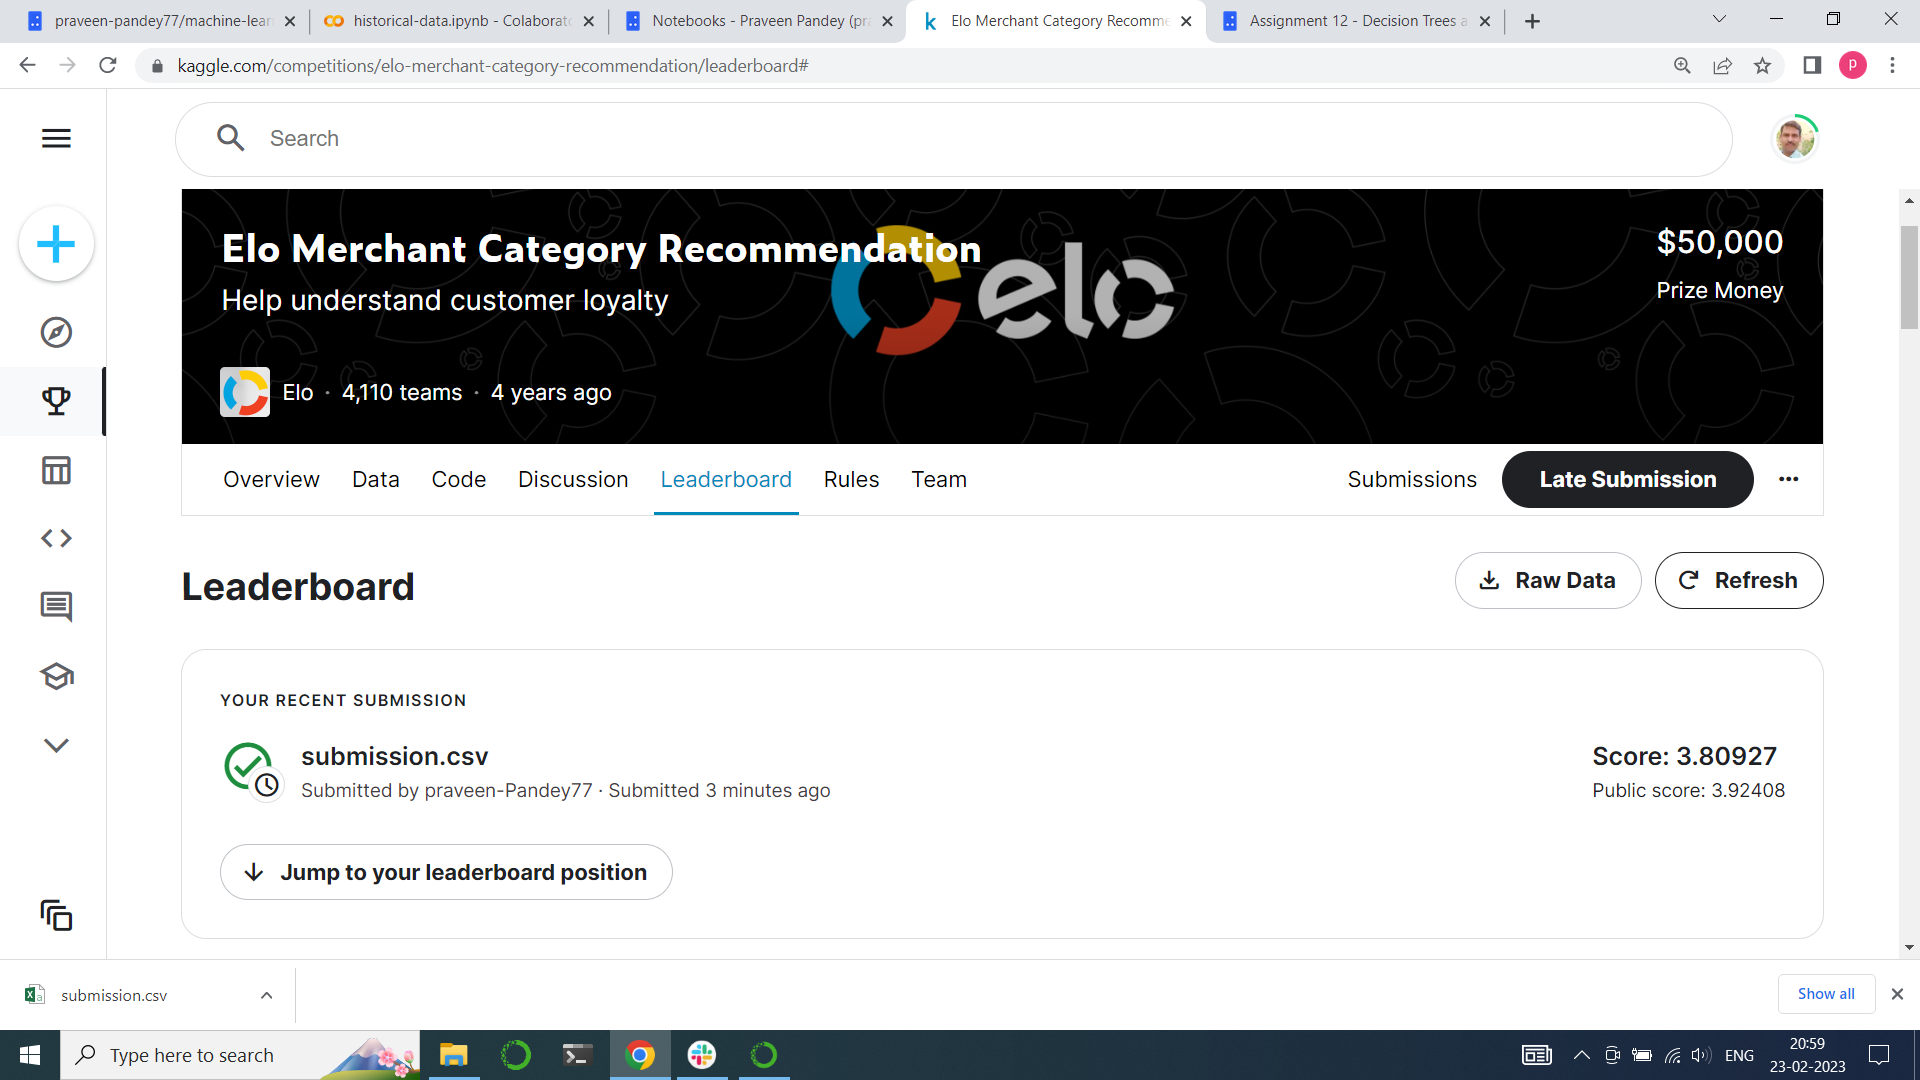

# summary and future work

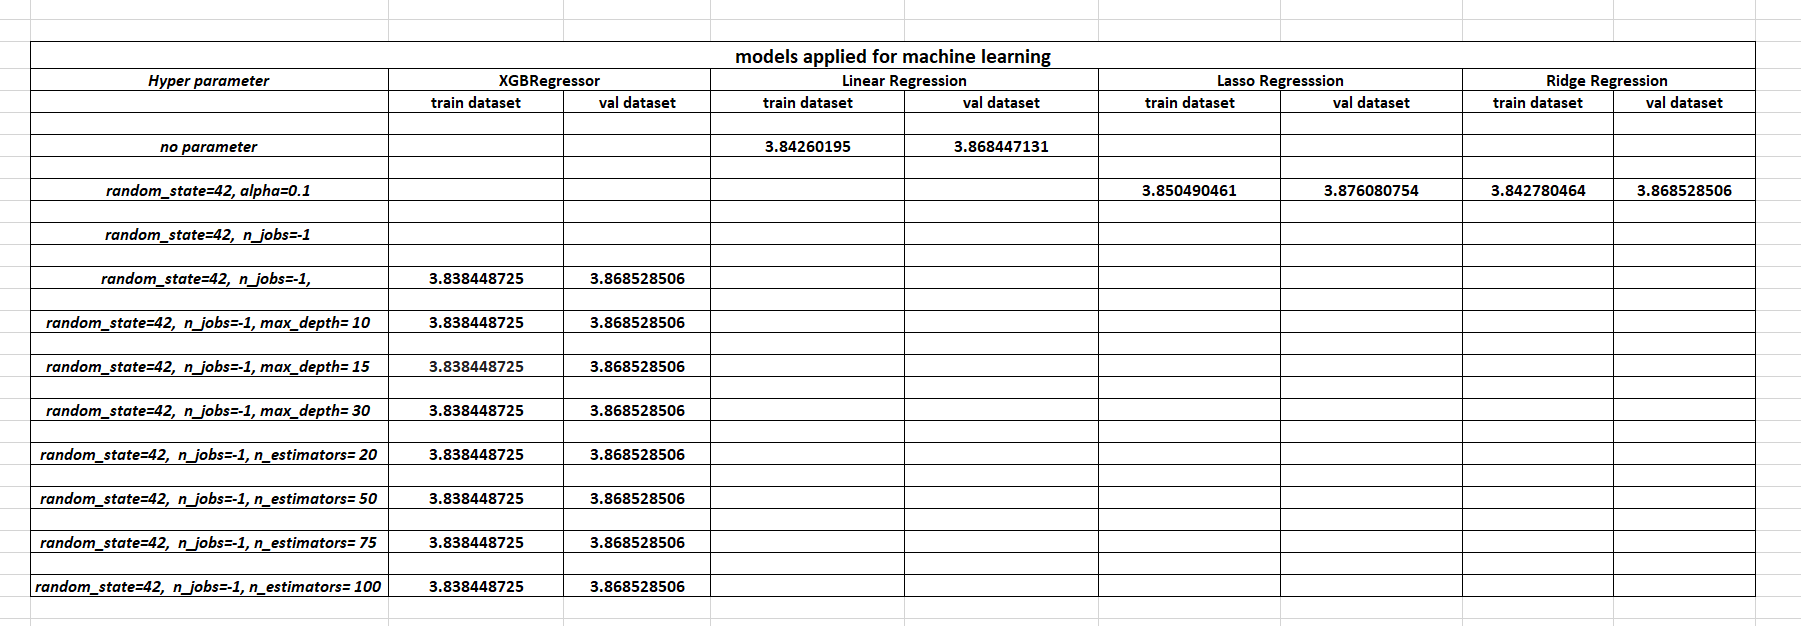

**summary**
* it is observed that XGBRegression model is best for this dataset. Other Models like Linear Regression and Lasso ane Ridge regression has almost same rmse value but XGBRegression has less rmse compared to the other regression.
* it is also observed when hyperparameter applied for max depth= 10,15,30 and n_estimators= 20,50,75,100 then rmse value for train and validation data are same. it's value doesn't effected

**Future work**
* my future planing is to combine other csv file with train dataset and test dataset. i would like to apply feature engineer which seems that it will be adavace step to create machine learning model.  when i will be more experiance in this field then i would work more on this project.

# Reference

https://www.w3schools.com/

https://stackoverflow.com/

https://scikit-learn.org/stable/user_guide.html

https://pandas.pydata.org/docs/user_guide/index.html

https://www.geeksforgeeks.org/introduction-to-seaborn-python/
